### Clock.fun: How it works

Each $TICKER swap is subject to a **10% tax**; that tax funds the **countdown pool**.

Every $TICKER buy has a chance to extend a global countdown (capped at 24 hours). The **last person to extend the timer wins the countdown pool**.

The chance of extending the timer is determined by the $TICKER buy size and current countdown pool size. This extension probability formula is designed to make the countdown pool grow at a faster rate than the buy amount required to extend the timer, making the game more appealing for players as the pool gets bigger.

---

### Extension probability

**Notation**

| Symbol | Meaning |
|--------|---------|
| $x$ | Buy size |
| $C$ | Countdown pool balance |
| $x_{100}$ | Buy size for 100% extension chance |
| $P_{\text{extend}}$ | Probability a buy of size $x$ extends the timer when pool = $C$ |

**Formula** (piecewise in $C$)

Effective pool:
$$C_{\text{eff}} = C^k \quad (0 < k < 1)$$

Threshold $x_{100}$:
$$x_{100} = \text{MIN\_PCT} \times \begin{cases} C & C < \text{PIVOT\_C0} \\ C^k & C \geq \text{PIVOT\_C0} \end{cases}$$

Probability:
$$P_{\text{extend}}(x, C) = \min\left(1, \frac{x}{x_{100}}\right)$$

**Constants** (ClockGameMechanics.sol)

| Parameter | Value |
|-----------|-------|
| $k$ | 0.65 |
| PIVOT_C0 | 1 ETH |
| MIN_PCT | 0.015% |
| EXTENSION_DELTA | 120 s |
| ROUND_LENGTH | 24 h |

**Example** — required buy for 100% extension

| Pool (ETH) | $x_{100}$ (ETH) | % of pool |
|------------|---------------------|-----------|
| 0.25 | 0.0000375 | 0.015% |
| 1.0 | 0.00015 | 0.015% |
| 2.5 | ~0.00027 | ~0.011% |
| 25 | ~0.0011 | ~0.0046% |
| 250 | ~0.0053 | ~0.002% |



In [33]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Model Parameters

The values below match the **production** on-chain contracts (`ClockGame.sol`, `ClockGameMechanics.sol`). All formulas in this notebook use these parameters.


In [34]:
# ============================================
# BASE PARAMETERS (production: ClockGame.sol, ClockGameMechanics.sol)
# ============================================

# ETH price for display only (formulas use ETH)
ETH_PRICE_USD = 3300.0
STARTING_POOL = 1

TAX_TO_POOL = 0.04 # 4% of swap goes to pool

# Power law: C_eff = C^K (ClockGameMechanics: K_POWER_LAW = 0.65)
K = 0.650

# Piecewise extension threshold (ClockGameMechanics: PIVOT_C0 = 1 ether, MIN_PCT = 0.015%)
PIVOT_C0 = 1.0              # 1 ETH
MIN_PCT = 0.00015           # 0.015% of effective pool for C >= PIVOT_C0

# Timer (ClockGameMechanics: EXTENSION_DELTA = 120, ROUND_LENGTH = 24 hours)
EXTENSION_SECONDS = 120     # Seconds added per successful extension (EXTENSION_DELTA)
ROUND_LENGTH_SECONDS = 24 * 3600   # 24 hours (ROUND_LENGTH)
SUSTAIN_SECONDS_PER_MIN = 60

EXTENSIONS_PER_MIN = SUSTAIN_SECONDS_PER_MIN / EXTENSION_SECONDS

# Precision (ClockGame: PRECISION_DENOMINATOR = 10_000_000)
PRECISION_PPM = 10_000_000

NUM_DAYS = 365 * 1

## Implementation

The functions below implement the extension-probability formula above.



In [35]:
def compute_x100(C):
    """Piecewise x_100 requirement.
    - For C < PIVOT_C0: x_100 = MIN_PCT * C
    - For C >= PIVOT_C0: x_100 = MIN_PCT * (C ** K)
    """
    if C < PIVOT_C0:
        return MIN_PCT * C
    return MIN_PCT * (C ** K)


def extension_probability(x, C):
    """
    Calculate extension probability using piecewise x_100.
    
    x_100(C) = {  MIN_PCT * C,             if C < PIVOT_C0
                  MIN_PCT * (C ** K),             if C >= PIVOT_C0 }
    
    P_extend = min(1, x / x_100)
    Returns probability as decimal (0 to 1)
    """
    if C == 0:
        return 1.0
    
    x_100 = compute_x100(C)
    if x_100 == 0:
        return 1.0
    
    prob = min(1.0, x / x_100)
    return prob

# Simulation: Sustained Timer with Countdown Pool Tax

The countdown pool receives **4%** of each buy (COUNTDOWN_POOL_FEE_BPS in ClockGame.sol). This simulation shows how the pool grows when the timer is sustained at a constant rate using the production parameters (120 s extension per successful extension, 4% to pool).



Running simulation...


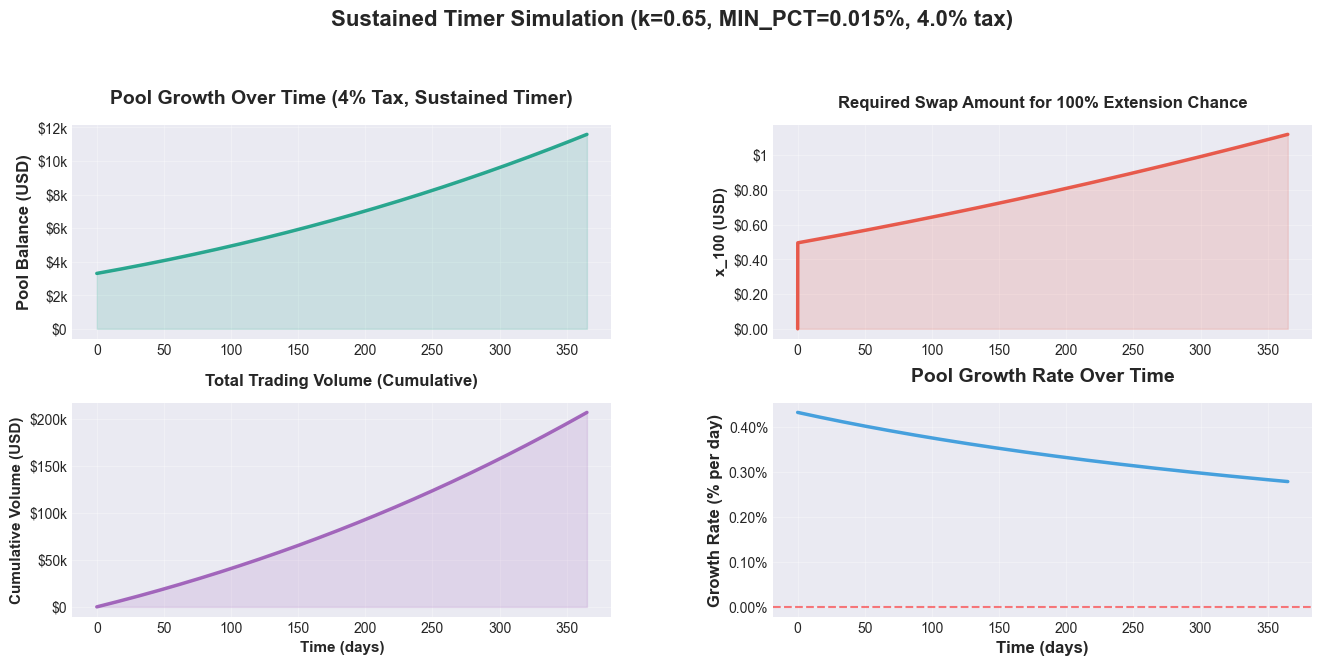

In [ ]:
TIME_STEP = 60 # Simulate in 1-minute increments
MAX_MINUTES = 60 * 24 * NUM_DAYS

swaps_per_timestep = TIME_STEP / EXTENSION_SECONDS

# Storage
pool_history = [STARTING_POOL]
time_history = [0]  # in minutes
swap_amount_history = [0]
total_volume_history = [0]

current_pool = STARTING_POOL
current_time = 0
total_volume = 0

for minute in range(1, MAX_MINUTES + 1):
    # Calculate x_100 based on current pool (piecewise)
    x_100 = compute_x100(current_pool)
    
    # This many swaps of x_100 needed to sustain timer
    total_swap_volume = x_100 * swaps_per_timestep
    
    # Pool grows by 4% of swap volume
    pool_growth = TAX_TO_POOL * total_swap_volume
    current_pool += pool_growth
    
    # Track totals
    total_volume += total_swap_volume
    current_time = minute
    
    # Store results (sample every 10 minutes to reduce data)
    if minute % 10 == 0:
        pool_history.append(current_pool)
        time_history.append(current_time)
        swap_amount_history.append(x_100)
        total_volume_history.append(total_volume)
    
    # Stop if pool gets too big
    if current_pool > 250_000:  # 250k ETH
        break


pool_history = np.array(pool_history)
time_history = np.array(time_history)
swap_amount_history = np.array(swap_amount_history)
total_volume_history = np.array(total_volume_history)

time_hours = time_history / 60
time_days = time_history / (60 * 24)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

pool_history_usd = pool_history * ETH_PRICE_USD
swap_amount_history_usd = swap_amount_history * ETH_PRICE_USD
total_volume_history_usd = total_volume_history * ETH_PRICE_USD

# Plot 1: Pool size over time (USD display)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time_days, pool_history_usd, linewidth=2.5, color='#16A085', alpha=0.9)
ax1.fill_between(time_days, 0, pool_history_usd, alpha=0.15, color='#16A085')
ax1.set_ylabel('Pool Balance (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Pool Growth Over Time (4% Tax, Sustained Timer)', fontsize=14, fontweight='bold', pad=15)
ax1.grid(alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else (f'${x/1000:.0f}k' if x >= 1000 else f'${x:.0f}')))

# Plot 2: x_100 (required swap for 100% extension) in USD
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time_days, swap_amount_history_usd, linewidth=2.5, color='#E74C3C', alpha=0.9)
ax2.fill_between(time_days, 0, swap_amount_history_usd, alpha=0.15, color='#E74C3C')
ax2.set_ylabel('x_100 (USD)', fontsize=11, fontweight='bold')
ax2.set_title('Required Swap Amount for 100% Extension Chance', fontsize=12, fontweight='bold', pad=12)
ax2.grid(alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}' if x >= 1 else f'${x:.2f}'))

# Plot 3: Cumulative volume (USD)
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(time_days, total_volume_history_usd, linewidth=2.5, color='#9B59B6', alpha=0.9)
ax3.fill_between(time_days, 0, total_volume_history_usd, alpha=0.15, color='#9B59B6')
ax3.set_xlabel('Time (days)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cumulative Volume (USD)', fontsize=11, fontweight='bold')
ax3.set_title('Total Trading Volume (Cumulative)', fontsize=12, fontweight='bold', pad=12)
ax3.grid(alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else (f'${x/1000:.0f}k' if x >= 1000 else f'${x:.0f}')))

# Plot 4: Pool growth rate (% per day)
if len(time_days) > 1:
    growth_rates = []
    for i in range(1, len(pool_history)):
        if time_days[i] > time_days[i-1]:
            days_elapsed = time_days[i] - time_days[i-1]
            growth = (pool_history[i] / pool_history[i-1] - 1) * 100 / days_elapsed  # % per day
            growth_rates.append(growth)
        else:
            growth_rates.append(0)
    
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(time_days[1:], growth_rates, linewidth=2.5, color='#3498DB', alpha=0.9)
    ax4.set_xlabel('Time (days)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Growth Rate (% per day)', fontsize=12, fontweight='bold')
    ax4.set_title('Pool Growth Rate Over Time', fontsize=14, fontweight='bold', pad=15)
    ax4.grid(alpha=0.3)
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}%'))

plt.suptitle(f'Sustained Timer Simulation (k={K}, MIN_PCT={MIN_PCT*100}%, {TAX_TO_POOL*100}% tax)', fontsize=16, fontweight='bold', y=0.995)

plt.show()